# Clustering based on chrom5k CGN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *
from ALLCools.mcds import MCDS

In [2]:
import os
os.chdir("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")

In [3]:
mcad = sc.read_h5ad("hh_mono_CGN_chrom5k.mcad")

In [4]:
mcad = mcad[mcad.obs["final_cluster"].isin(["Micro1", "Micro2", "Monocytes"])]

In [5]:
binarize_matrix(mcad, cutoff=0.95)

In [6]:
filter_regions(mcad)

123693 regions remained.


## LSI decomposition

In [7]:
# PC cutoff
pc_cutoff = 0.1
resolution = 1

In [8]:
lsi(mcad, algorithm="arpack", obsm="X_pca")
n_components = significant_pc_test(mcad, p_cutoff=0.1, update=True)

13 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (2934, 100) to (2934, 13)


In [9]:
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

In [10]:
try:
    sc.tl.paga(mcad, groups="leiden")
    sc.pl.paga(mcad, plot=False)
    sc.tl.umap(mcad, init_pos="paga")
except:
    sc.tl.umap(mcad)

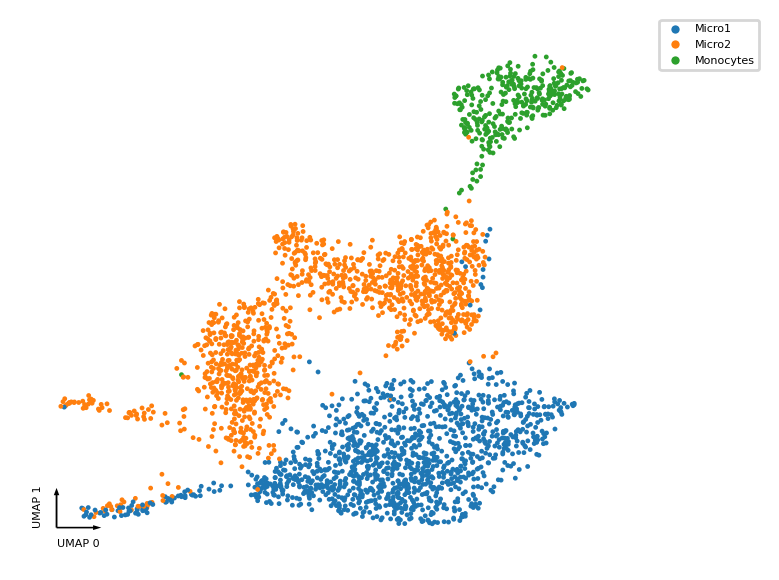

In [11]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
_ = categorical_scatter(data=mcad, ax=ax, coord_base="umap", hue="final_cluster", show_legend=True)
plt.tight_layout()

In [12]:
mcad.obs = mcad.obs[["final_cluster"]].copy()
mcad.write_h5ad("hh_mono_micro_CGN_chrom5k.mcad")

## Consensus clustering

In [13]:
import pathlib
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.clustering import ConsensusClustering, Dendrogram, get_pc_centers
from ALLCools.plot import *

In [14]:
# clustering name
clustering_name = "L1"

# input data
# cell_meta_path = "dHIP_map3c_meta.tsv"
adata_path = "hh_mono_micro_CGN_chrom5k.mcad"
coord_base = "umap"

# ConsensusClustering
n_neighbors = 25
metric = "euclidean"
min_cluster_size = 10
consensus_rate = 0.5
leiden_repeats = 500
leiden_resolution = 0.5
random_state = 0
n_jobs = 40
train_frac = 0.5
train_max_n = 500
max_iter = 20

# Dendrogram via Multiscale Bootstrap Resampling
nboot = 10000
method_dist = "correlation"
method_hclust = "average"

plot_type = "static"

In [15]:
# cell_meta = pd.read_csv(cell_meta_path, index_col=0, sep="\t")
adata = anndata.read_h5ad(adata_path)

In [16]:
cc = ConsensusClustering(
    model=None,
    n_neighbors=n_neighbors,
    metric=metric,
    min_cluster_size=min_cluster_size,
    leiden_repeats=leiden_repeats,
    leiden_resolution=leiden_resolution,
    consensus_rate=consensus_rate,
    random_state=random_state,
    train_frac=train_frac,
    train_max_n=train_max_n,
    max_iter=max_iter,
    n_jobs=n_jobs
)

In [17]:
if "X_pca" not in adata.obsm:
    raise KeyError(
        "X_pca do not exist in the adata file, run PCA first before clustering."
    )
cc.fit_predict(adata.obsm["X_pca"])

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 500 times
Found 7 - 8 clusters, mean 7.2, std 0.42
Summarizing multiple clustering results
2933 cells assigned to 7 raw clusters
1 cells are multi-leiden outliers

=== Start supervise model training and cluster merging ===

=== iteration 1 ===
7 non-outlier labels
Balanced accuracy on the training set: 0.970
Balanced accuracy on the hold-out set: 0.951
Stop iteration because current accuracy 0.951 > target accuracy 0.950.

=== Assign final labels ===
Assigned all the multi-leiden clustering outliers into clusters using the prediction model from final clustering version.
Final ten-fold CV Accuracy on all the cells: 0.963


In [18]:
adata.obs[f"{coord_base}_0"] = adata.obsm[f"X_{coord_base}"][:, 0]
adata.obs[f"{coord_base}_1"] = adata.obsm[f"X_{coord_base}"][:, 1]

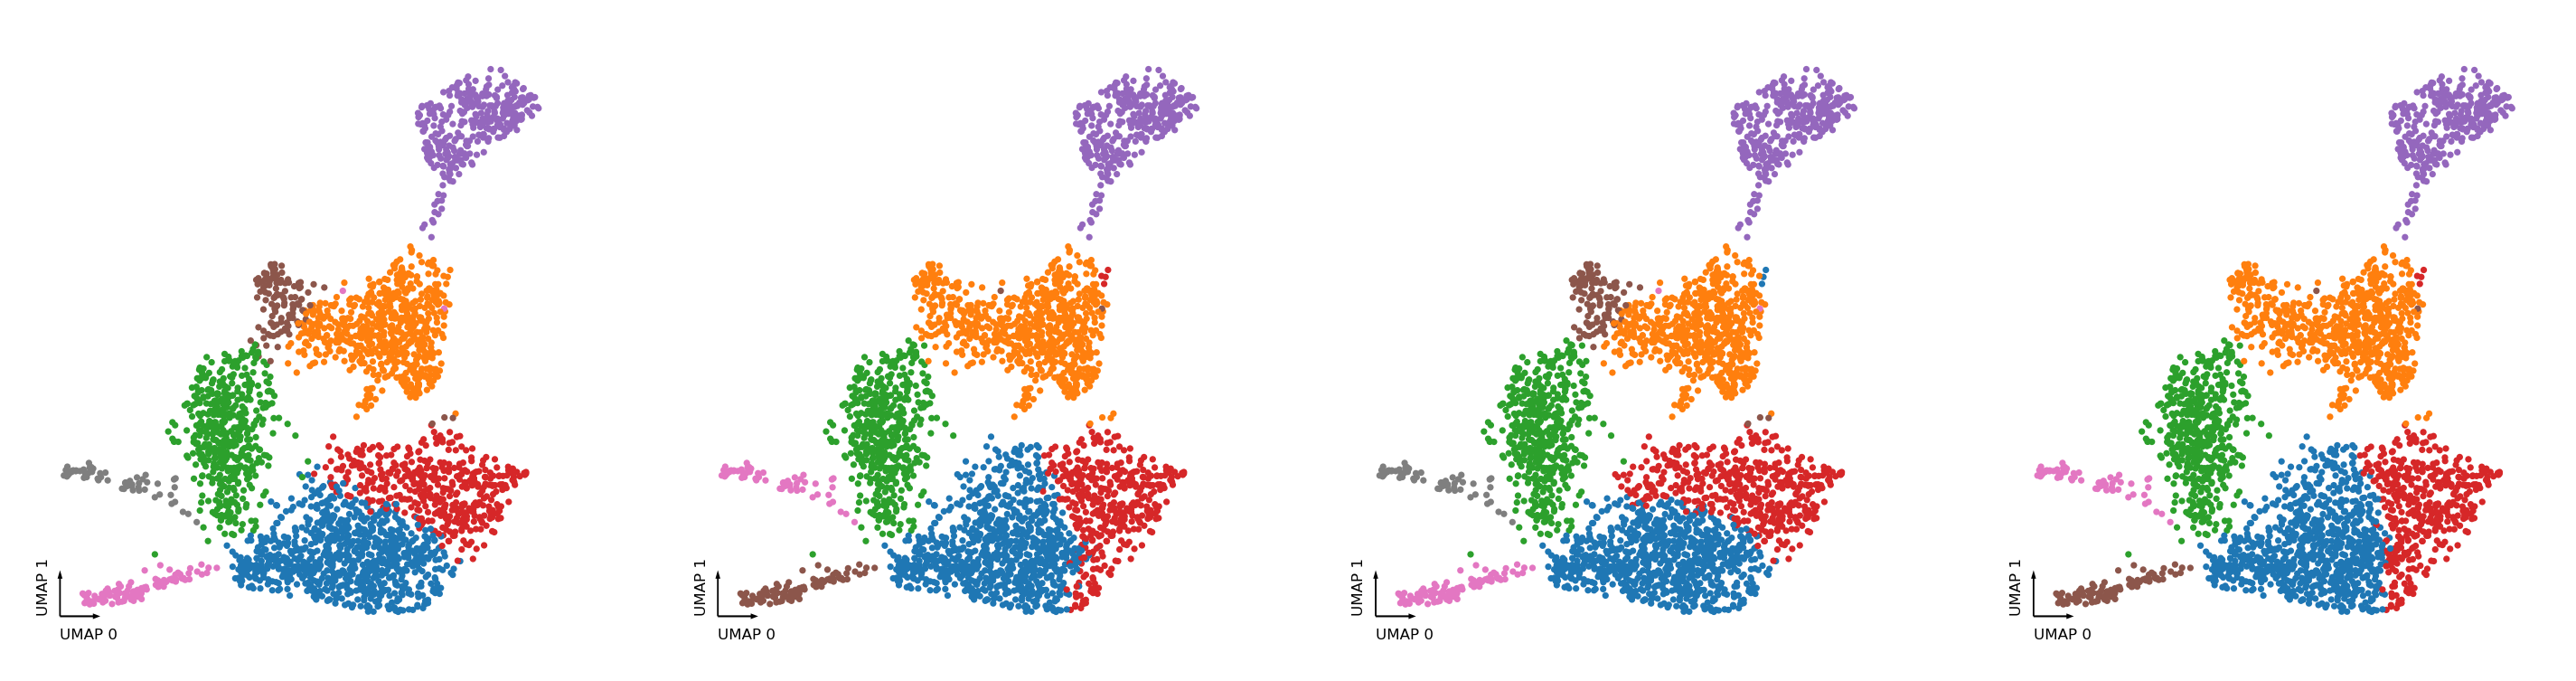

In [19]:
fig, axes = cc.plot_leiden_cases(
    coord_data=adata.obs,
    coord_base=coord_base
)

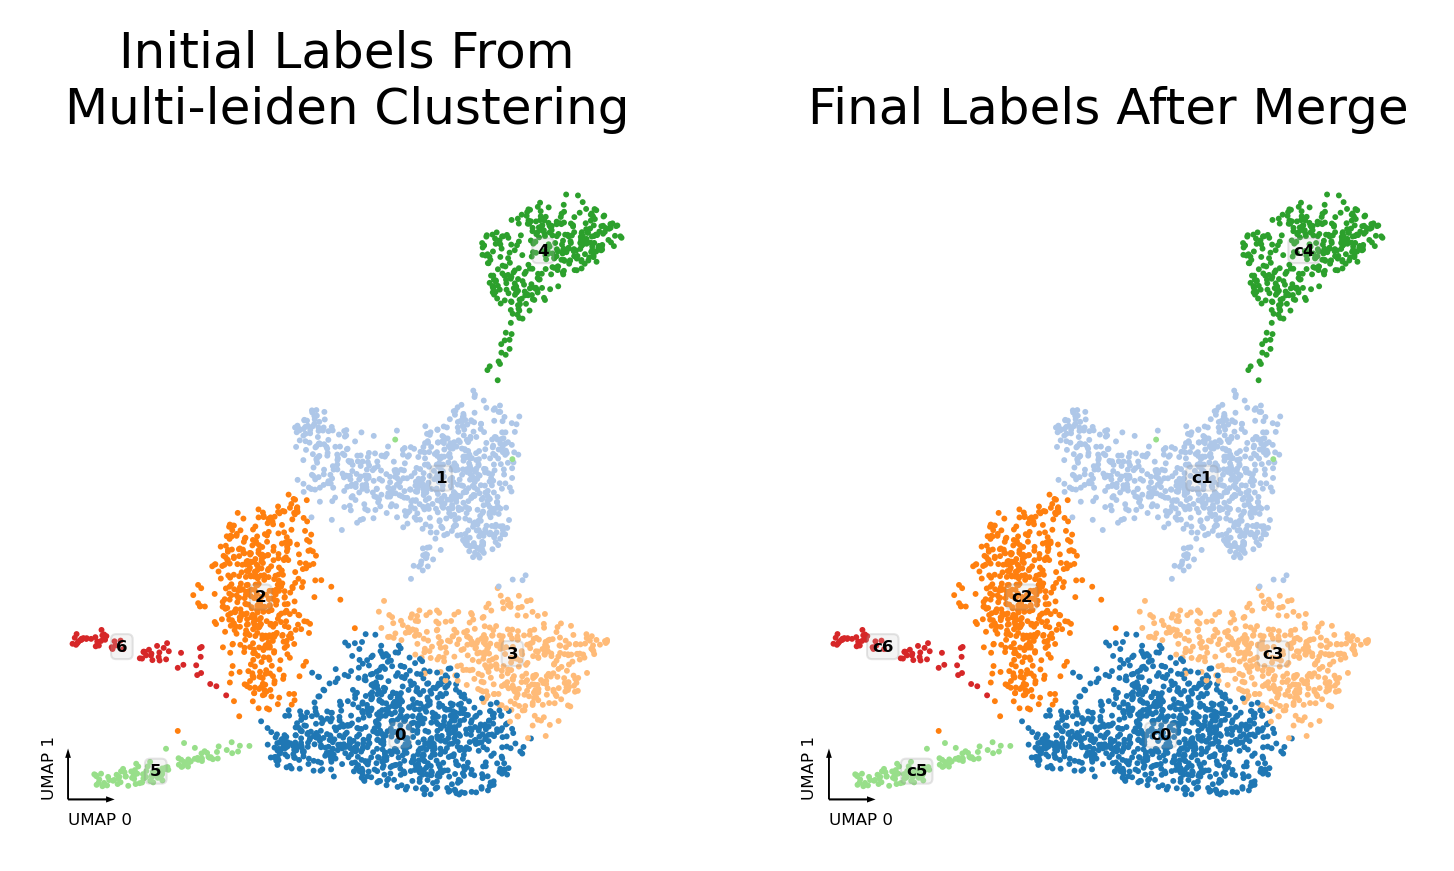

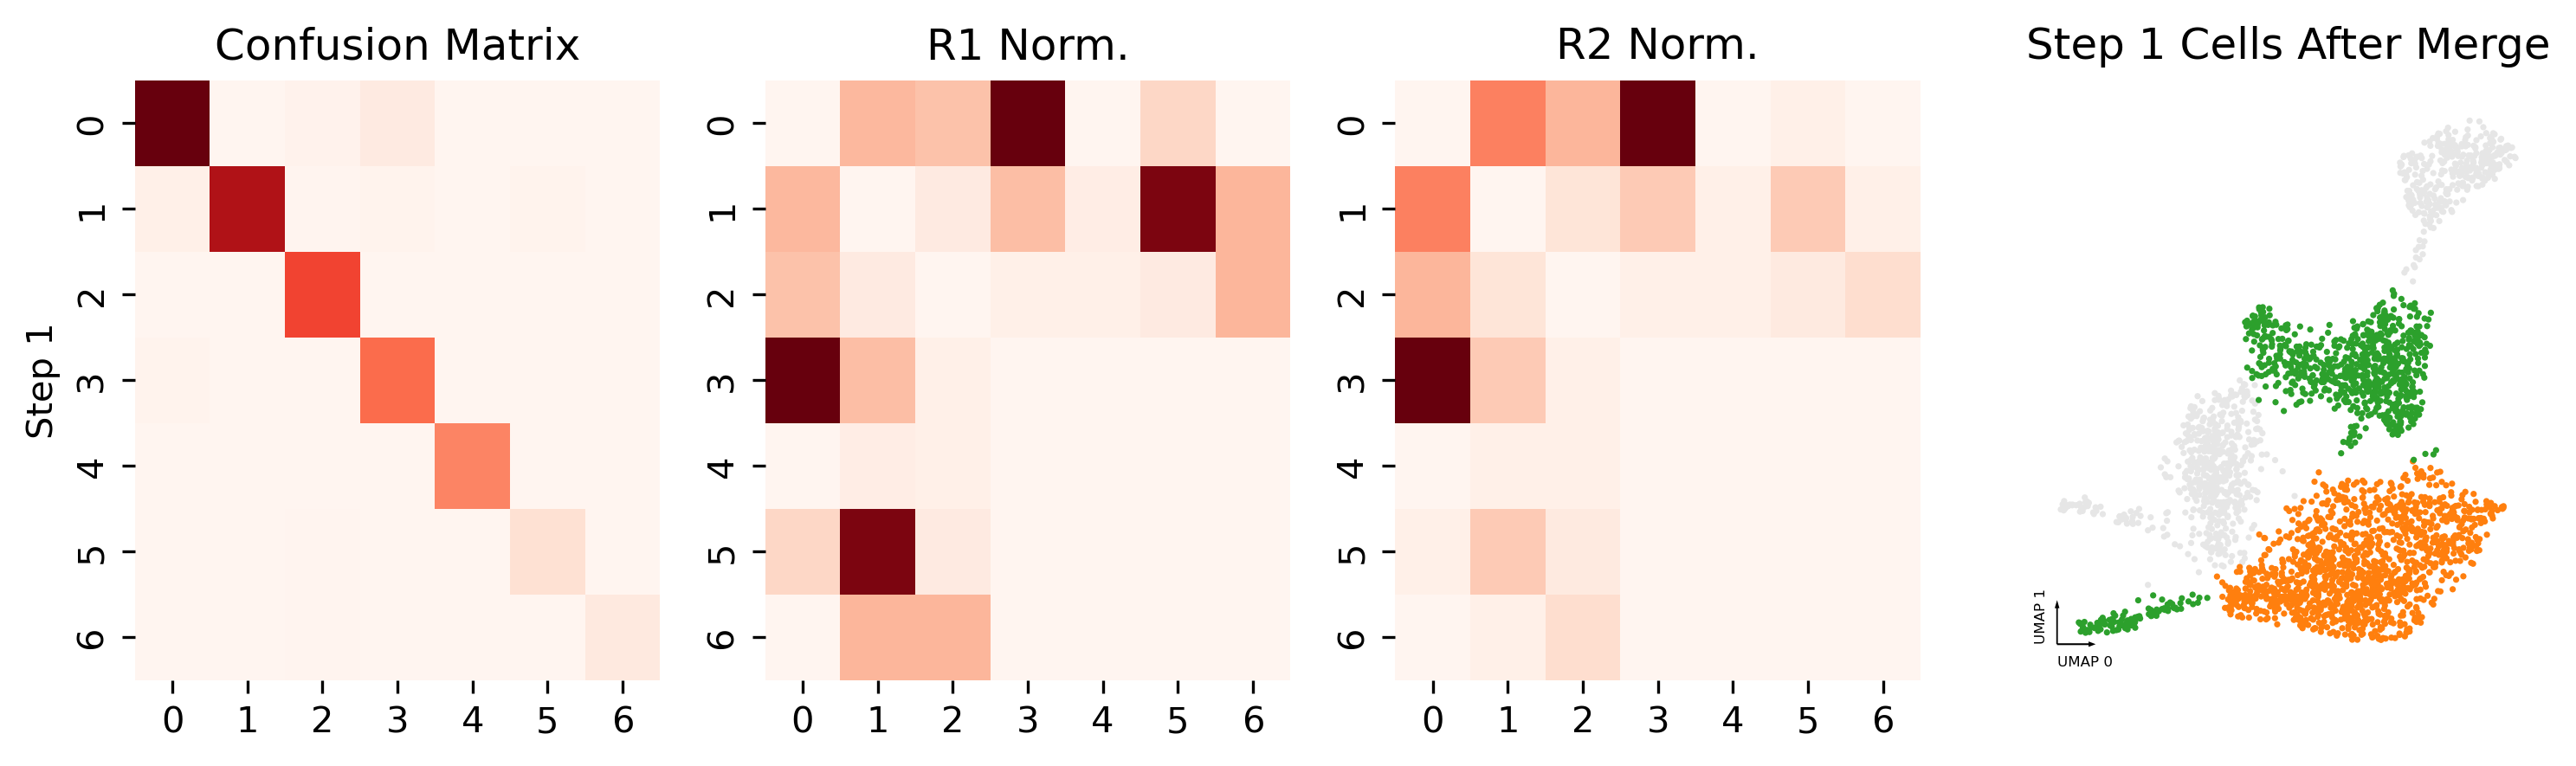

In [20]:
cc.plot_steps(coord_data=adata.obs, coord_base=coord_base)

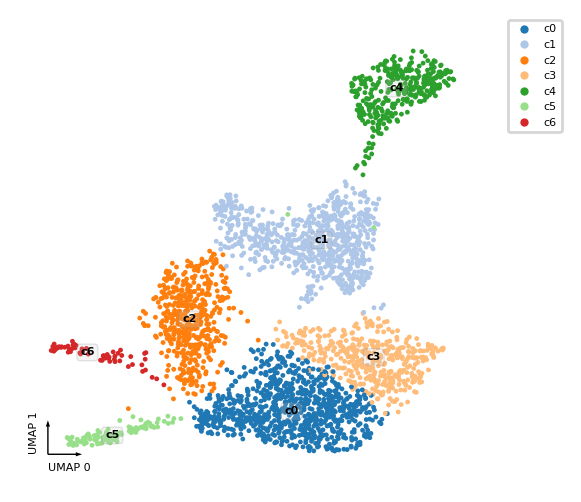

In [21]:
adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
_ = categorical_scatter(
    data=adata.obs,
    ax=ax,
    hue=clustering_name,
    coord_base=coord_base,
    palette="tab20",
    text_anno=clustering_name,
    show_legend=True
)

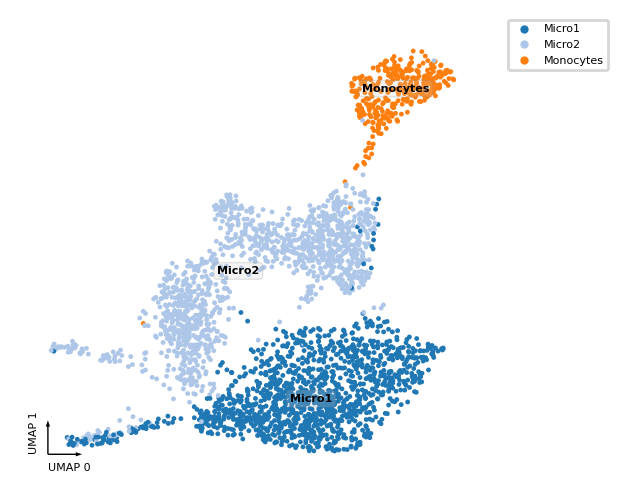

In [26]:
adata.obs[clustering_name] = cc.label

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
_ = categorical_scatter(
    data=adata.obs,
    ax=ax,
    hue="final_cluster",
    coord_base=coord_base,
    palette="tab20",
    text_anno="final_cluster",
    show_legend=True
)
plt.savefig("results/mono_micro_only.pdf", dpi=300, bbox_inches="tight")

In [23]:
adata.write_h5ad(adata_path)